# Capstone

### Introduction etc etc

***
***

# Imports, Loading Data

In [119]:
#imports
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import datetime
import re
import string
import seaborn as sns
import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

#models:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

import tensorflow as tf
from keras.optimizers import SGD
from tensorflow.keras import preprocessing
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#seed for reproducible results
np.random.seed(42)
tf.random.set_seed(42)

##### explain datset in detail

In [82]:
data_dir_depression = './data/depression_dataset_reddit_cleaned.csv'

depression_df = pd.read_csv(data_dir_depression)

# EDA and Preprocessing

## Exploratory Data Analysis

In [83]:
#change to df for ease of use
df = depression_df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7731 entries, 0 to 7730
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_text     7731 non-null   object
 1   is_depression  7731 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 120.9+ KB


In [84]:
df.head()

,clean_text,is_depression
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1


In [85]:
df.isna().sum()

clean_text       0
is_depression    0
dtype: int64

In [86]:
df['is_depression'].value_counts()

0    3900
1    3831
Name: is_depression, dtype: int64

##### ______ discuss balance_____________________

In [87]:
# SHOW VISUALIZATION

In [88]:
df['islowercase'] = list(map(lambda x: x.islower(), df['clean_text']))
df['islowercase'].value_counts()

True    7731
Name: islowercase, dtype: int64

## Preprocessing Data

Explain __________________________________________________________________________________________

will create variations of columns to be able to experiment with different options (with/without stopwords, etc)

### Lowercase Text

In this case, the text data from the downloaded dataset is already lowercase, so we do not need to take this step!

In [89]:
# df['lower_text'] = df['clean_text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# df['lower_text'].head()

### Tokenize
Explain __________________________________________________________________________________________

In [90]:
def tokenize_data(data):
    
    #(this regex code keeps words with apostrophes as single tokens)
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    
    #create tokens
    tokens = nltk.regexp_tokenize(data, pattern)
    return [word for word in tokens]

In [91]:
df['tokenized'] = df.apply(lambda x: tokenize_data(x['clean_text']), axis=1)
df['tokenized'].head()

0    [we, understand, that, most, people, who, repl...
1    [welcome, to, r, depression, s, check, in, pos...
2    [anyone, else, instead, of, sleeping, more, wh...
3    [i, ve, kind, of, stuffed, around, a, lot, in,...
4    [sleep, is, my, greatest, and, most, comfortin...
Name: tokenized, dtype: object

### Stopwords
Explain __________________________________________________________________________________________

In [92]:
#show top FreqDist of Tokenized Column
FreqDist(sum(df['tokenized'], [])).most_common(50)

[('i', 40411),
 ('to', 17965),
 ('and', 16326),
 ('a', 12638),
 ('the', 11932),
 ('my', 11430),
 ('it', 9976),
 ('of', 7738),
 ('t', 7698),
 ('me', 6941),
 ('that', 6506),
 ('in', 6088),
 ('m', 5758),
 ('but', 5427),
 ('is', 5324),
 ('for', 5196),
 ('have', 5007),
 ('this', 4557),
 ('just', 4527),
 ('so', 4337),
 ('s', 4073),
 ('with', 3869),
 ('wa', 3810),
 ('like', 3584),
 ('not', 3275),
 ('feel', 3227),
 ('can', 3217),
 ('be', 3158),
 ('on', 3075),
 ('don', 3029),
 ('do', 2874),
 ('you', 2836),
 ('or', 2553),
 ('all', 2490),
 ('at', 2430),
 ('about', 2348),
 ('get', 2316),
 ('want', 2292),
 ('know', 2283),
 ('if', 2154),
 ('life', 2147),
 ('out', 2106),
 ('ve', 2096),
 ('up', 2082),
 ('time', 2069),
 ('what', 2057),
 ('been', 2024),
 ('am', 1983),
 ('because', 1922),
 ('they', 1885)]

In [93]:
stops = stopwords.words('english')

#add punctuation
for symbol in ",.'?!()":
    stops += symbol

    #show example of stopwords list
print(stops)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [94]:
def tokenize_remove_stops(data):
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    tokens = nltk.regexp_tokenize(data, pattern)
    return [word for word in tokens if word not in stops]

In [95]:
df['tokenized_no_stops'] = df.apply(lambda x: tokenize_remove_stops(x['clean_text']), axis=1)

#show difference
df[['tokenized','tokenized_no_stops']].head()

,tokenized,tokenized_no_stops
0,"[we, understand, that, most, people, who, repl...","[understand, people, reply, immediately, op, i..."
1,"[welcome, to, r, depression, s, check, in, pos...","[welcome, r, depression, check, post, place, t..."
2,"[anyone, else, instead, of, sleeping, more, wh...","[anyone, else, instead, sleeping, depressed, s..."
3,"[i, ve, kind, of, stuffed, around, a, lot, in,...","[kind, stuffed, around, lot, life, delaying, i..."
4,"[sleep, is, my, greatest, and, most, comfortin...","[sleep, greatest, comforting, escape, whenever..."


In [96]:
#show top FreqDist now that stopwords are removed!
freq_minus_stops = FreqDist(sum(df['tokenized_no_stops'], []))
freq_minus_stops.most_common(50)

[('wa', 3810),
 ('like', 3584),
 ('feel', 3227),
 ('get', 2316),
 ('want', 2292),
 ('know', 2283),
 ('life', 2147),
 ('time', 2069),
 ('even', 1812),
 ('day', 1688),
 ('people', 1660),
 ('really', 1617),
 ('depression', 1569),
 ('anxiety', 1548),
 ('thing', 1534),
 ('one', 1522),
 ('year', 1438),
 ('go', 1398),
 ('friend', 1297),
 ('would', 1285),
 ('think', 1280),
 ('going', 1252),
 ('ha', 1243),
 ('make', 1210),
 ('much', 1131),
 ('never', 1114),
 ('work', 1093),
 ('back', 1049),
 ('help', 1022),
 ('feeling', 948),
 ('im', 939),
 ('thought', 915),
 ('got', 915),
 ('still', 897),
 ('way', 839),
 ('good', 819),
 ('need', 818),
 ('anything', 808),
 ('bad', 802),
 ('always', 801),
 ('anyone', 787),
 ('everything', 785),
 ('see', 782),
 ('something', 779),
 ('better', 743),
 ('could', 740),
 ('last', 731),
 ('anymore', 725),
 ('every', 723),
 ('also', 720)]

# _____________ REMOVE OBVIOUS WORDS SKEWING TARGET DATA _____ View Frequency of Words by Class ___________________

### Lemmatization
explain __________________________________________________________________________________________

In [97]:
lemmatizer = WordNetLemmatizer()

def lemmatize_data(data):
    return [lemmatizer.lemmatize(word) for word in data]
    

In [98]:
df['lemmatized'] = df['tokenized'].apply(lemmatize_data)
df['lemmatized'].head()

0    [we, understand, that, most, people, who, repl...
1    [welcome, to, r, depression, s, check, in, pos...
2    [anyone, else, instead, of, sleeping, more, wh...
3    [i, ve, kind, of, stuffed, around, a, lot, in,...
4    [sleep, is, my, greatest, and, most, comfortin...
Name: lemmatized, dtype: object

In [99]:
df['lemmatized_no_stops'] = df['tokenized_no_stops'].apply(lemmatize_data)
df['lemmatized_no_stops'].head()

0    [understand, people, reply, immediately, op, i...
1    [welcome, r, depression, check, post, place, t...
2    [anyone, else, instead, sleeping, depressed, s...
3    [kind, stuffed, around, lot, life, delaying, i...
4    [sleep, greatest, comforting, escape, whenever...
Name: lemmatized_no_stops, dtype: object

In [100]:
df.head()

,clean_text,is_depression,islowercase,tokenized,tokenized_no_stops,lemmatized,lemmatized_no_stops
0,we understand that most people who reply immed...,1,True,"[we, understand, that, most, people, who, repl...","[understand, people, reply, immediately, op, i...","[we, understand, that, most, people, who, repl...","[understand, people, reply, immediately, op, i..."
1,welcome to r depression s check in post a plac...,1,True,"[welcome, to, r, depression, s, check, in, pos...","[welcome, r, depression, check, post, place, t...","[welcome, to, r, depression, s, check, in, pos...","[welcome, r, depression, check, post, place, t..."
2,anyone else instead of sleeping more when depr...,1,True,"[anyone, else, instead, of, sleeping, more, wh...","[anyone, else, instead, sleeping, depressed, s...","[anyone, else, instead, of, sleeping, more, wh...","[anyone, else, instead, sleeping, depressed, s..."
3,i ve kind of stuffed around a lot in my life d...,1,True,"[i, ve, kind, of, stuffed, around, a, lot, in,...","[kind, stuffed, around, lot, life, delaying, i...","[i, ve, kind, of, stuffed, around, a, lot, in,...","[kind, stuffed, around, lot, life, delaying, i..."
4,sleep is my greatest and most comforting escap...,1,True,"[sleep, is, my, greatest, and, most, comfortin...","[sleep, greatest, comforting, escape, whenever...","[sleep, is, my, greatest, and, most, comfortin...","[sleep, greatest, comforting, escape, whenever..."


##### __DISCUSS DATASET__

# Modeling

## Preparing Train and Test Data`

##### __EXPLAIN STARTING FEATURE CHOICE, TARGET, ETC__
## ____

also talk about data sizes

### explain vectorizer

In [123]:
vectorizer = TfidfVectorizer()

### Rejoin Data

for tfidf vectorizer

In [101]:
def rejoin_words(column):
    return ( " ".join(column))

df['rejoined_lemmatized'] = df.apply(lambda x: rejoin_words(x['lemmatized']), axis=1)

In [102]:
df['rejoined_lemmatized'].head()

0    we understand that most people who reply immed...
1    welcome to r depression s check in post a plac...
2    anyone else instead of sleeping more when depr...
3    i ve kind of stuffed around a lot in my life d...
4    sleep is my greatest and most comforting escap...
Name: rejoined_lemmatized, dtype: object

In [124]:
X = vectorizer.fit_transform(df['rejoined_lemmatized'])
y = df['is_depression']

In [125]:
#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# #create validation set from test data
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, stratify=y_test, test_size=0.5, random_state=42)

In [126]:
X_test.size
#etc

63953

data sizes

### Metrics and Scoring
explain metric options

ideal scores

## baseline model - Logistic Regression

explain model choice


In [62]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.naive_bayes import GaussianNB, MultinomialNB
# from sklearn.svm import SVC
# from sklearn.linear_model import LogisticRegression



### explain pipeline

In [127]:
lr_model = LogisticRegression()

In [128]:
lr_model.fit(X_train, y_train)

LogisticRegression()

In [129]:
y_pred = lr_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       780
           1       0.99      0.93      0.96       767

    accuracy                           0.96      1547
   macro avg       0.96      0.96      0.96      1547
weighted avg       0.96      0.96      0.96      1547



In [130]:
# create confusion matrix helper function:
def plot_confusion(title, save_name):

    #confusion matrix for test data
    conf_matrix = confusion_matrix(y_test,y_pred)

    # plot confusion matrix values
    sns.heatmap(
    conf_matrix, 
    annot=True, 
    cmap='Blues', 
    fmt='0.5g'
    )

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)

    plt.savefig('./img/'+save_name+'.png')
    plt.show()

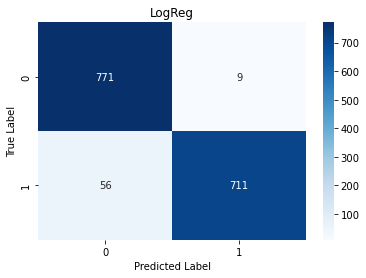

In [131]:
plot_confusion('LogReg', 'logreg_base')

In [142]:
vocab = vectorizer.vocabulary_

# Get the coefficients of the model
coef = lr_model.coef_[0]

# Create a DataFrame with the coefficients
coef_df = pd.DataFrame({'word': list(vocab.keys()), 'coef': coef})

# Print the most prominent words in each class
print(coef_df[coef_df['coef'] < 0].sort_values('coef', ascending=True))[0:10]

                   word      coef
14994          buttload -2.051887
14150             loses -1.918344
18369               cpu -1.800378
3051               anti -1.719759
13173           vpllqru -1.656870
...                 ...       ...
16321         pineapple -0.000358
15588  keeeerrrrriiiiii -0.000340
18016               cob -0.000155
14434               wty -0.000058
700                slow -0.000016

[5488 rows x 2 columns]


TypeError: 'NoneType' object is not subscriptable

# TOO MUCH OBVIOUS WORDAGE, REMOVE IN PREPROCESSING

## can always analyze futher at this point to identify more coefficients/features to remove though

gridsearch pipelines to choose model

best model play with hyperparameters

talk about word embeddings

rnn? implement at least a glimpse into neural networks